# ** All Cancer Rates US Counties 2017-2021 

In [127]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import folium
from folium.plugins import MarkerCluster
import sqlite3


# Read the All_cancer_rate CSV file,into pandas dataframe
all_cancer_df = pd.read_csv("../Cancer_Cartographers/Source_Data/All_Cancer_Rates_US_Counties_2017-2021.csv")

# # Display the first few rows of the data
all_cancer_df.head()

,County,FIPS,2023 Rural-Urban Continuum Codes([rural urban note]),"Age-Adjusted Incidence Rate([rate note]) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,CI*Rank([rank note]),Lower CI (CI*Rank),Upper CI (CI*Rank),Average Annual Count,Recent Trend,Recent 5-Year Trend ([trend note]) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1
0,US (SEER+NPCR)(1),0.0,NaN,444.4,444.1,444.7,N/A,N/A,N/A,1744459,falling,-0.5,-0.7,-0.3
1,"Union County, Florida(6)",12125.0,Rural,1248.4,1177.5,1322.7,N/A,N/A,N/A,245,stable,0.4,-0.6,1.5
2,"Traverse County, Minnesota(6)",27155.0,Rural,693.5,588.2,814.3,N/A,N/A,N/A,37,stable,2.2,-0.9,5.5
3,"Polk County, Texas(7)",48373.0,Rural,679.5,648.4,711.8,N/A,N/A,N/A,436,stable,-0.3,-3.1,2.5
4,"Galax City, Virginia(6)",51640.0,Rural,655,577.7,740.2,N/A,N/A,N/A,55,stable,1.7,-0.7,4


# ** Data Cleaning

In [128]:
# Keep only 'County', 'FIPS', and 'Average Annual Count' columns
all_cancer_cleaned = all_cancer_df[['County', 'FIPS', 'Average Annual Count']]

# Split 'County' into 'County' and 'State'
all_cancer_cleaned[['County', 'State']] = all_cancer_cleaned['County'].str.split(', ', n=1, expand=True)

# Fill missing 'State' values with 'Unknown'
all_cancer_cleaned['State'].fillna('Unknown', inplace=True)

# Convert FIPS column to numeric, coercing errors to NaN, then dropping NaN values
all_cancer_cleaned['FIPS'] = pd.to_numeric(all_cancer_cleaned['FIPS'], errors='coerce')
all_cancer_cleaned.dropna(subset=['FIPS'], inplace=True)

# Convert 'Average Annual Count' to numeric, coercing errors to NaN
all_cancer_cleaned['Average Annual Count'] = pd.to_numeric(all_cancer_cleaned['Average Annual Count'], errors='coerce')

# Remove non-county data (rows like "US", "Puerto Rico", etc.)
exclude_list = ['US', 'Puerto Rico', '(1)', '(6)']
all_cancer_cleaned = all_cancer_cleaned[~all_cancer_cleaned['County'].str.contains('|'.join(exclude_list))]

# Filter out rows with missing or zero 'Average Annual Count'
all_cancer_cleaned = all_cancer_cleaned[all_cancer_cleaned['Average Annual Count'] > 0]

# Save the cleaned data to a new CSV file
cleaned_file_path = '../Cancer_Cartographers/Clean_files/cleaned_all_cancer_data.csv'
all_cancer_cleaned.to_csv(cleaned_file_path, index=False)

# Display the cleaned data
all_cancer_cleaned.head(), cleaned_file_path

all_cancer_cleaned.head()

/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/3478418431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cancer_cleaned[['County', 'State']] = all_cancer_cleaned['County'].str.split(', ', n=1, expand=True)
/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/3478418431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cancer_cleaned[['County', 'State']] = all_cancer_cleaned['County'].str.split(', ', n=1, expand=True)
/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn

,County,FIPS,Average Annual Count,State
1,Union County,12125.0,245.0,Florida(6)
2,Traverse County,27155.0,37.0,Minnesota(6)
3,Polk County,48373.0,436.0,Texas(7)
4,Galax City,51640.0,55.0,Virginia(6)
5,Greeley County,31077.0,21.0,Nebraska(6)


# ** code for Visualisation

/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/1662884474.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='State', x='Average Annual Count', data=State_all_cancer.head(30), palette='viridis')


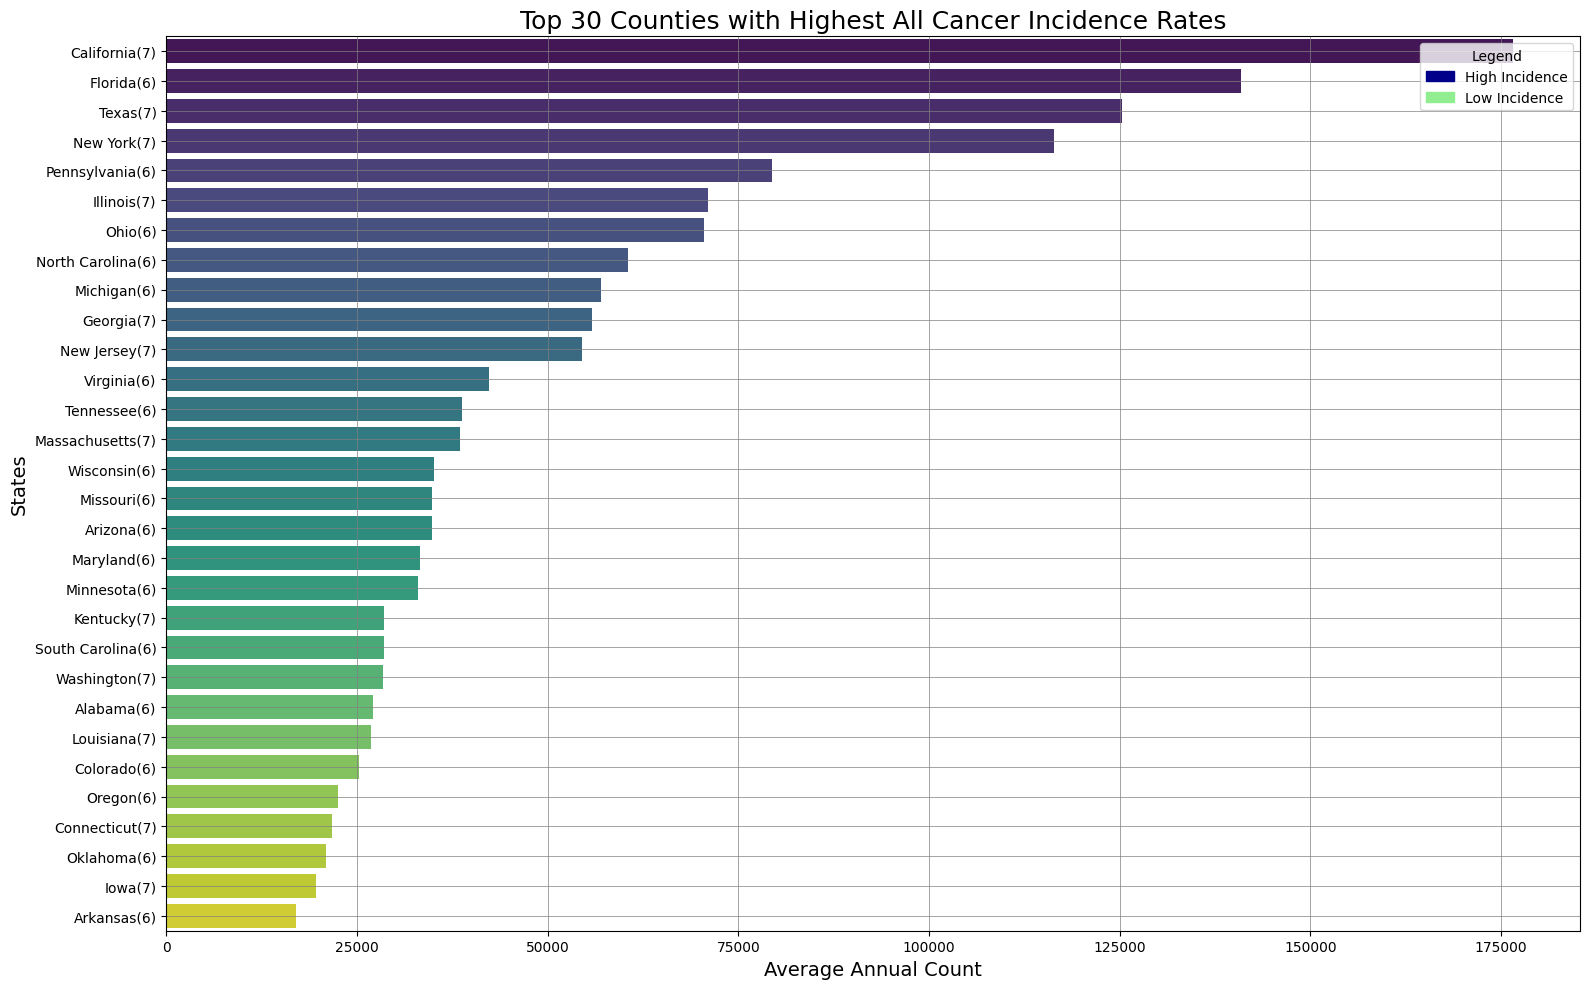

In [140]:
# Aggregate data by state and sum the 'Average Annual Count'
State_all_cancer = all_cancer_cleaned.groupby('State')['Average Annual Count'].sum().reset_index()

# Sort the data by cancer incidence in descending order
State_all_cancer = State_all_cancer.sort_values(by='Average Annual Count', ascending=False)

# Set the figure size
plt.figure(figsize=(16, 10))

# Create a horizontal bar chart using Seaborn
sns.barplot(y='State', x='Average Annual Count', data=State_all_cancer.head(30), palette='viridis')

# Add labels and title
plt.title('Top 30 Counties with Highest All Cancer Incidence Rates', fontsize=18)
plt.xlabel('Average Annual Count', fontsize=14)
plt.ylabel('States', fontsize=14)

# Add a colorful grid
plt.grid(color='gray', linestyle='-', linewidth=0.5)

# Create custom legend patches
high_patch = mpatches.Patch(color='darkblue', label='High Incidence')
low_patch = mpatches.Patch(color='lightgreen', label='Low Incidence')

# Add custom legend to the plot
plt.legend(handles=[high_patch, low_patch], title='Legend', loc='upper right')

# Use tight layout for better spacing
plt.tight_layout()

# Save the plot as an image
plt.savefig('../Cancer_Cartographers/Temporary_outputs/top_and_bottom_30_counties_cancer_incidents.png')

# Display the chart
plt.show()

/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/142732681.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State', y='Average Annual Count', data=state_all_cancer, palette='viridis')


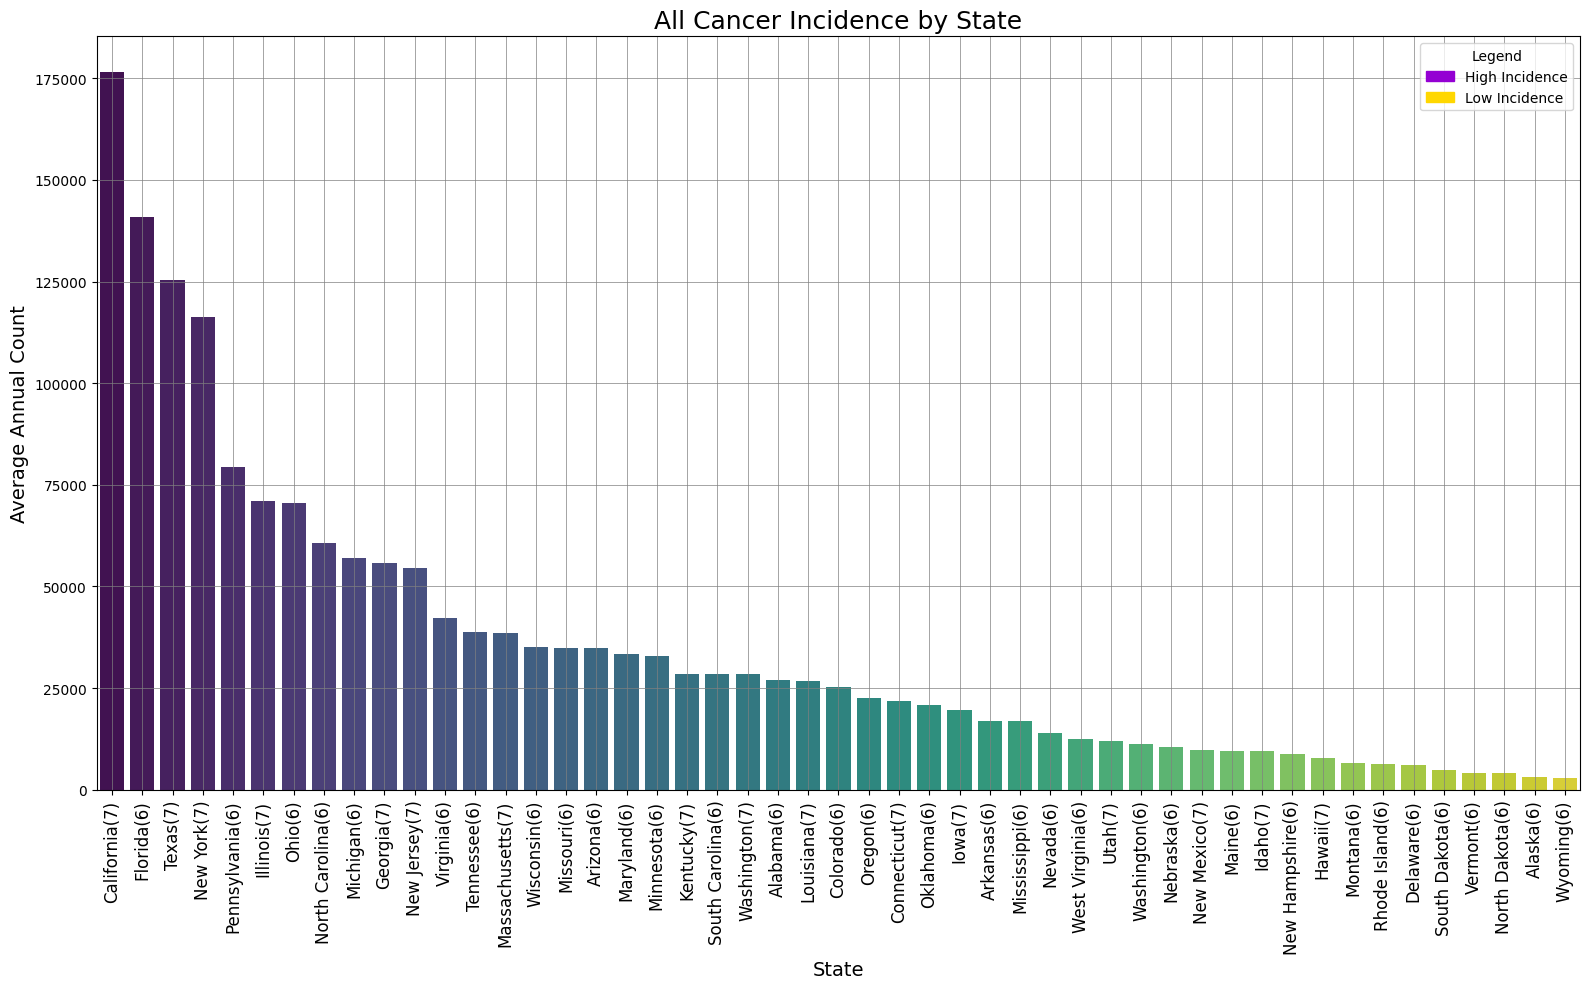

In [142]:
# Aggregate data by state and sum the 'Average Annual Count'
state_all_cancer = all_cancer_cleaned.groupby('State')['Average Annual Count'].sum().reset_index()

# Sort the data by cancer incidence in descending order
state_all_cancer = state_all_cancer.sort_values(by='Average Annual Count', ascending=False)

# Set the figure size
plt.figure(figsize=(16, 10))

# Create the bar chart using Seaborn
sns.barplot(x='State', y='Average Annual Count', data=state_all_cancer, palette='viridis')

# Set chart title and labels
plt.title('All Cancer Incidence by State', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Annual Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# Add a colorful grid
plt.grid(color='gray', linestyle='-', linewidth=0.5)

# Create custom legend patches
high_patch = mpatches.Patch(color='darkviolet', label='High Incidence')
low_patch = mpatches.Patch(color='gold', label='Low Incidence')

# Add custom legend to the plot
plt.legend(handles=[high_patch, low_patch], title='Legend', loc='upper right')

# Use tight layout for better spacing
plt.tight_layout()

# Save the plot as an image
plt.savefig('../Cancer_Cartographers/Temporary_outputs/all_cancer_incidence_by_state.png')

# Display the chart
plt.show()

# ** Breast_cancer_Rates_us_2017_2021

In [ ]:
# Read the Breast_Cancer CSV file,into pandas dataframe
Breast_Cancer_df = pd.read_csv("../Cancer_Cartographers/Source_Data/Breast_Cancer_Rates_US_Counties_2017-2021.csv")

# # Display the first few rows of the dataframe
Breast_Cancer_df.head()

,County,FIPS,2023 Rural-Urban Continuum Codes([rural urban note]),"Age-Adjusted Incidence Rate([rate note]) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,CI*Rank([rank note]),Lower CI (CI*Rank),Upper CI (CI*Rank),Average Annual Count,Recent Trend,Recent 5-Year Trend ([trend note]) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1
0,US (SEER+NPCR)(1),0.0,NaN,129.8,129.5,130,N/A,N/A,N/A,258398,rising,0.6,0.4,0.8
1,"Armstrong County, Texas(7)",48011.0,Urban,279.6,152.3,473.3,N/A,N/A,N/A,3,*,*,*,*
2,"Aurora County, South Dakota(6)",46003.0,Rural,265.3,160,416.1,N/A,N/A,N/A,5,rising,18.4,5.4,50.1
3,"Webster County, Georgia(7)",13307.0,Rural,248,143.6,404.6,N/A,N/A,N/A,4,*,*,*,*
4,"Haakon County, South Dakota(6)",46055.0,Rural,233.5,121.8,412.6,N/A,N/A,N/A,3,*,*,*,*


# ** DATA CLEANING FOR BREAST CANCER 

In [ ]:
# Columns to keep
columns_to_keep = ["County", "FIPS", "Average Annual Count"]
    
# Drop all other columns
Breast_Cancer_df_filtered = Breast_Cancer_df[columns_to_keep]
    
Breast_Cancer_df_filtered

Breast_Cancer_df_filtered.head()

# Split the 'County' column into 'County' and 'State'
split_Breast_Cancer_df_filtered = Breast_Cancer_df_filtered['County'].str.split(', ', expand=True)
Breast_Cancer_df_filtered['County'] = split_Breast_Cancer_df_filtered[0]

Breast_Cancer_df_filtered['State'] = split_Breast_Cancer_df_filtered[1].str.extract(r'([A-Za-z\s]+)')




# Display the the first few rows of data after spliting the 'County' column into 'County' and 'State'
Breast_Cancer_df_filtered.head()

# Drop rows where 'County' or 'State' columns have NaN values
Breast_Cancer_df_filtered_cleaned = Breast_Cancer_df_filtered.dropna(subset=['County', 'State'])

Breast_Cancer_df_filtered_cleaned


cleaned_Breast_cancer_csv_path = "../Cancer_Cartographers/Clean_files/cleaned_Breast_Cancer_data.csv"  # Define the path and name of the new CSV
Breast_Cancer_df_filtered_cleaned.to_csv(cleaned_Breast_cancer_csv_path, index=False)

# Display the fiirst few rows of data after dropping the where 'County' or 'State' columns have NaN values
Breast_Cancer_df_filtered_cleaned


/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/2309498159.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Breast_Cancer_df_filtered['County'] = split_Breast_Cancer_df_filtered[0]
/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/2309498159.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Breast_Cancer_df_filtered['State'] = split_Breast_Cancer_df_filtered[1].str.extract(r'([A-Za-z\s]+)')


,County,FIPS,Average Annual Count,State
1,Armstrong County,48011.0,3,Texas
2,Aurora County,46003.0,5,South Dakota
3,Webster County,13307.0,4,Georgia
4,Haakon County,46055.0,3,South Dakota
5,Traverse County,27155.0,5,Minnesota
...,...,...,...,...
3139,Wrangell Borough,2275.0,3 or fewer,Alaska
3140,Wyandotte County,20209.0,data not available,Kansas
3141,Yakutat City and Borough,2282.0,3 or fewer,Alaska
3142,Yukon-Koyukuk Census Area,2290.0,3 or fewer,Alaska


# ** Breast Cancer Visualisation : Top 30 most and least Effected Counties in the United states of America

/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/1404988553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Breast_Cancer_df_filtered_cleaned['Average Annual Count'] = pd.to_numeric(Breast_Cancer_df_filtered_cleaned['Average Annual Count'], errors='coerce')
/var/folders/1y/lrsrz62n53qfv18krp557w8w0000gn/T/ipykernel_38531/1404988553.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=combined_counties['Average Annual Count'], y=combined_counties['County'], shade=True)


<Axes: xlabel='Average Annual Count', ylabel='County'>

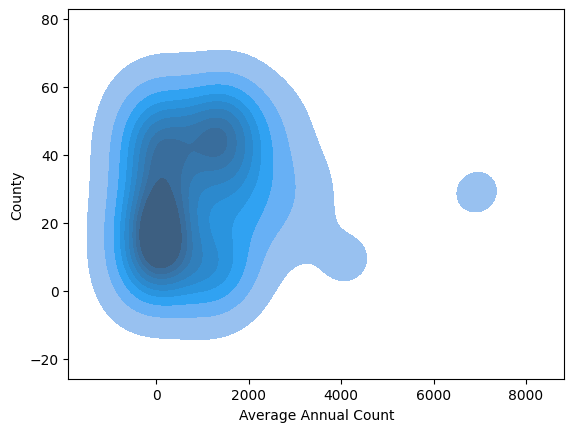

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Replace non-numeric values with NaN and then drop them          #####################subject to debug##############################
Breast_Cancer_df_filtered_cleaned['Average Annual Count'] = pd.to_numeric(Breast_Cancer_df_filtered_cleaned['Average Annual Count'], errors='coerce')
Breast_Cancer_df_filtered_cleaned = Breast_Cancer_df_filtered_cleaned.dropna(subset=['Average Annual Count'])

# Sort the DataFrame by 'Average Annual Count' and get the top 30 and bottom 30 counties
top_30_counties = Breast_Cancer_df_filtered_cleaned.nlargest(30, 'Average Annual Count')
bottom_30_counties = Breast_Cancer_df_filtered_cleaned.nsmallest(30, 'Average Annual Count')

# Combine top and bottom counties for plotting
combined_counties = pd.concat([top_30_counties, bottom_30_counties])



combined_counties['County'] = combined_counties['County'].astype('category').cat.codes
#df['CategoryNumeric'] = df['Category'].astype('category'


# Create the bar plot
sns.kdeplot(x=combined_counties['Average Annual Count'], y=combined_counties['County'], shade=True)

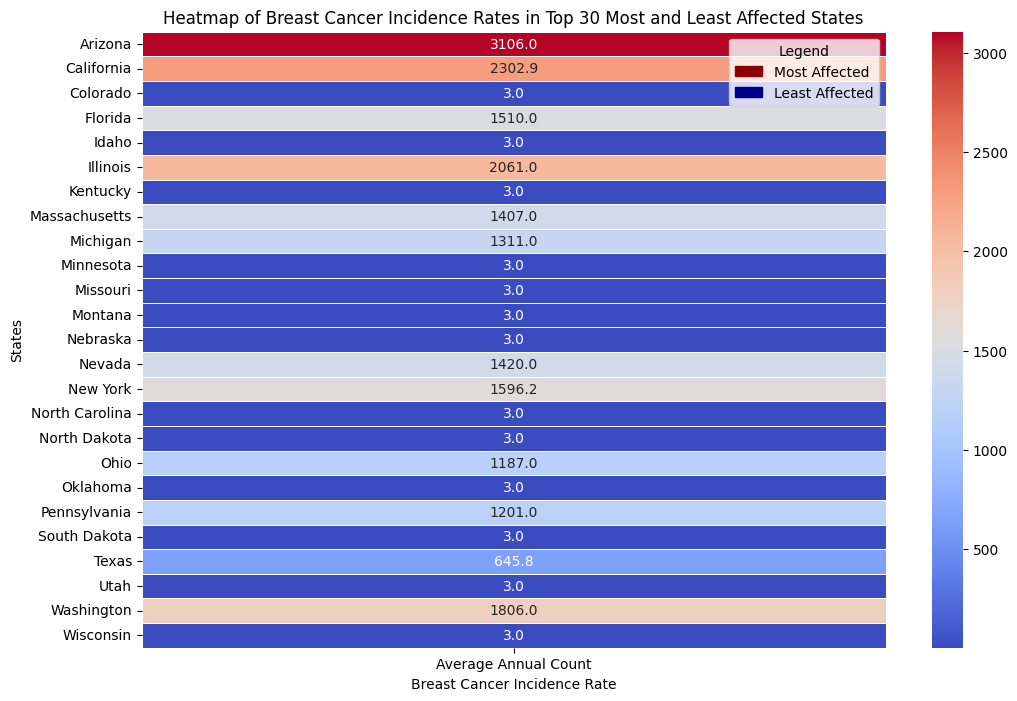

In [ ]:
Breast_Cancer_df_filtered_cleaned['Average Annual Count'] = pd.to_numeric(Breast_Cancer_df_filtered_cleaned['Average Annual Count'], errors='coerce')
Breast_Cancer_df_filtered_cleaned = Breast_Cancer_df_filtered_cleaned.dropna(subset=['Average Annual Count'])

# Sort the DataFrame by 'Average Annual Count' and get the top 30 and bottom 30 counties
#top_30_counties = Breast_Cancer_df_filtered_cleaned.nlargest(30, 'Average Annual Count')
#bottom_30_counties = Breast_Cancer_df_filtered_cleaned.nsmallest(30, 'Average Annual Count')

# Sort the DataFrame by 'Average Annual Count' and get the top 30 and bottom 30 States
top_30_States = Breast_Cancer_df_filtered_cleaned.nlargest(30, 'Average Annual Count')
bottom_30_states = Breast_Cancer_df_filtered_cleaned.nsmallest(30, 'Average Annual Count')


# Combine top and bottom States for plotting

combined_States = pd.concat([top_30_Sates, bottom_30_states])


# Create a pivot table to arrange data for the heatmap
heatmap_data = combined_States.pivot_table(index='State', values='Average Annual Count', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)

# Add labels and title
plt.xlabel('Breast Cancer Incidence Rate')
plt.ylabel('States')
plt.title('Heatmap of Breast Cancer Incidence Rates in Top 30 Most and Least Affected States')

# Create custom legend patches
top_patch = mpatches.Patch(color='darkred', label='Most Affected')
bottom_patch = mpatches.Patch(color='darkblue', label='Least Affected')

# Add custom legend to the plot
plt.legend(handles=[top_patch, bottom_patch], title='Legend', loc='upper right')
# Save the plot as an image
plt.savefig('../Cancer_Cartographers/Temporary_outputs/heatmap_top_and_bottom_30_States.png')

# Show plot
plt.show()

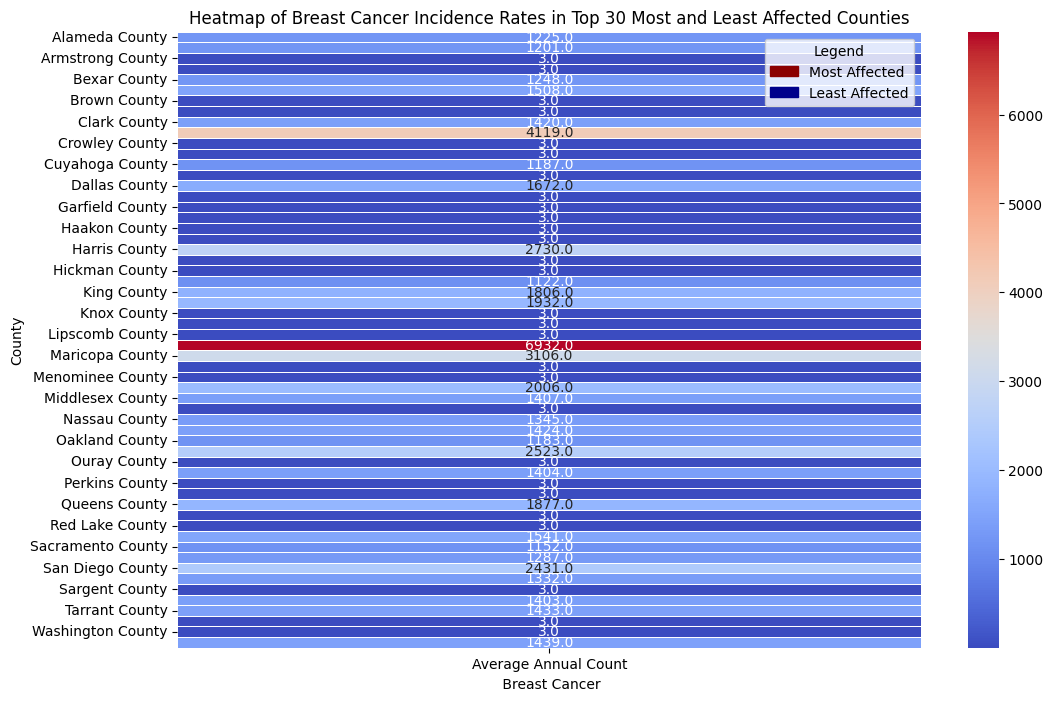

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Replace non-numeric values with NaN and then drop them
Breast_Cancer_df_filtered_cleaned['Average Annual Count'] = pd.to_numeric(Breast_Cancer_df_filtered_cleaned['Average Annual Count'], errors='coerce')
Breast_Cancer_df_filtered_cleaned = Breast_Cancer_df_filtered_cleaned.dropna(subset=['Average Annual Count'])

# Sort the DataFrame by 'Average Annual Count' and get the top 30 and bottom 30 counties
top_30_counties = Breast_Cancer_df_filtered_cleaned.nlargest(30, 'Average Annual Count')
bottom_30_counties = Breast_Cancer_df_filtered_cleaned.nsmallest(30, 'Average Annual Count')

# Combine top and bottom counties for plotting
combined_counties = pd.concat([top_30_counties, bottom_30_counties])

# Create a pivot table to arrange data for the heatmap
heatmap_data = combined_counties.pivot_table(index='County', values='Average Annual Count', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)

# Add labels and title
plt.xlabel(' Breast Cancer')
plt.ylabel('County')
plt.title('Heatmap of Breast Cancer Incidence Rates in Top 30 Most and Least Affected Counties')

# Create custom legend patches
top_patch = mpatches.Patch(color='darkred', label='Most Affected')
bottom_patch = mpatches.Patch(color='darkblue', label='Least Affected')

# Add custom legend to the plot
plt.legend(handles=[top_patch, bottom_patch], title='Legend', loc='upper right')

# Save the plot as an image
plt.savefig('../Cancer_Cartographers/Temporary_outputs/heatmap_top_and_bottom_30_counties.png')

# Show plot
plt.show()




Nuclear Data

In [ ]:
#Read the csv file from github

url = "../Cancer_Cartographers/Clean_files/Nuclear_data.csv"
Nuclear_data_df = pd.read_csv(url)
Nuclear_data_df.head()

,FID,Region,Country,Plant,NumReactor,Latitude,Longitude
0,3,America - Northern,UNITED STATES OF AMERICA,ARKANSAS ONE,2,35.310320,-93.231289
1,9,America - Northern,UNITED STATES OF AMERICA,BEAVER VALLEY,2,40.621900,-80.433900
2,16,America - Northern,UNITED STATES OF AMERICA,BIG ROCK POINT,1,45.358889,-85.197222
3,21,America - Northern,UNITED STATES OF AMERICA,BONUS,1,18.366389,-67.268611
4,24,America - Northern,UNITED STATES OF AMERICA,BRAIDWOOD,2,41.243600,-88.228900


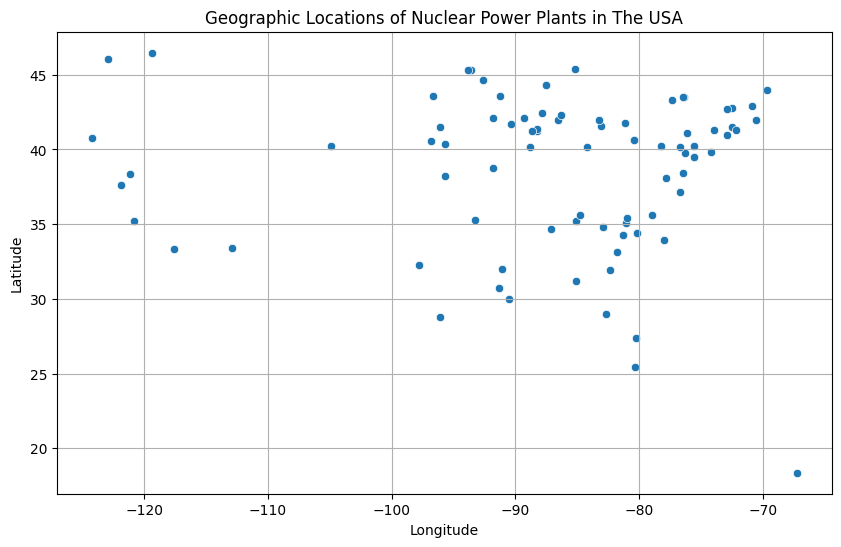

In [ ]:
# Create DataFrame
Nuclear_df = pd.DataFrame(Nuclear_data_df)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', data=Nuclear_df)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Locations of Nuclear Power Plants in The USA')
plt.grid(True)
plt.savefig("../Cancer_Cartographers/Temporary_outputs/Geographic Locations of Nuclear Power Plants in the USA")
# Show plot
plt.show()

# ** BASIC HTML FOR VISUALIZATION**


In [ ]:

import folium


Nuclear_data = pd.read_csv("../Cancer_Cartographers/Clean_files/Nuclear_data.csv")



# Initialize the map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Centered on the USA

# Add markers to the map
for idx, row in Nuclear_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Plant: {row['Plant']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Save the map to an HTML file
m.save('../Cancer_Cartographers/Temporary_outputs/nuclear_plants_interactive_map.html')



# ** Cancer by County

In [ ]:
filepath = '../Cancer_Cartographers/gz_2010_us_050_00_5m.json'
cancer_by_county = pd.read_json(filepath, encoding='latin-1')
cancer_by_county.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '..."
